In [1]:
# Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [2]:
# load from csv
df = pd.read_csv("merged_dataset.csv")
print(df.info())
print(df.describe())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25119 entries, 0 to 25118
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       25119 non-null  object
 1   expression  25119 non-null  int64 
 2   dataset     25119 non-null  object
dtypes: int64(1), object(2)
memory usage: 588.9+ KB
None
         expression
count  25119.000000
mean       3.076476
std        2.017876
min        0.000000
25%        1.000000
50%        3.000000
75%        5.000000
max        6.000000
                                        image  expression    dataset
0    ./datasets/affectnet/surprise/ffhq_1.png           0  affectnet
1   ./datasets/affectnet/surprise/ffhq_10.png           0  affectnet
2  ./datasets/affectnet/surprise/ffhq_100.png           0  affectnet
3  ./datasets/affectnet/surprise/ffhq_101.png           0  affectnet
4  ./datasets/affectnet/surprise/ffhq_102.png           0  affectnet


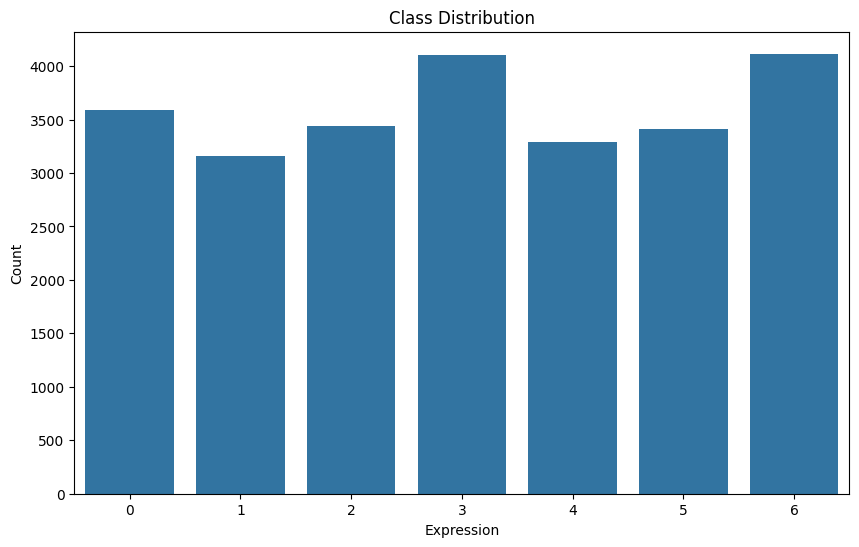

In [3]:
# show class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x="expression", data=df)
plt.title("Class Distribution")
plt.xlabel("Expression")
plt.ylabel("Count")
plt.show()

In [4]:
import cv2
from tqdm import tqdm

images = []
labels = []


def load_data(path, label):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    images.append(img_rgb)
    labels.append(label)


for i in tqdm(range(len(df))):
    load_data(df["image"][i], df["expression"][i])

images = np.array(images)
labels = np.array(labels)

100%|██████████| 25119/25119 [00:11<00:00, 2257.31it/s]


In [5]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.20)

# Normalize the data
# X_train = X_train / 255.0
# X_test = X_test / 255.0

2025-02-20 01:13:16.948660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-20 01:13:16.998973: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-20 01:13:17.008577: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 01:13:17.031688: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-20 01:13:18.141108: W tensorflow/compiler/tf2

In [6]:
# CNN and DenseNet require images to have shape (height, width, channels)
# Reshape the images
X_train = X_train.reshape(-1, 96, 96, 3)
X_test = X_test.reshape(-1, 96, 96, 3)

y_train = to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

# To enhance the model's ability to generalize, data augmentation is applied using ImageDataGenerator.
# This involves applying random transformations, which helps the model become more robust to variations in the input images.

gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    zoom_range=0.1,
    channel_shift_range=50,
    fill_mode="nearest",
)

train_generator = gen.flow(X_train, y_train, batch_size=64)

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
import kerastuner as kt  # Убедитесь, что установили библиотеку: pip install -U keras-tuner


def build_model(hp):
    # Входной слой
    input_img = Input(shape=(96, 96, 3))

    # Первый сверточный блок
    filters1 = hp.Choice("filters1", values=[32, 64, 128], default=64)
    x = Conv2D(filters1, (3, 3), activation="relu")(input_img)
    x = MaxPooling2D((2, 2))(x)

    # Второй сверточный блок
    filters2 = hp.Choice("filters2", values=[64, 128, 256], default=128)
    x = Conv2D(filters2, (3, 3), activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)

    # Третий сверточный блок
    filters3 = hp.Choice("filters3", values=[64, 128, 256], default=128)
    x = Conv2D(filters3, (3, 3), activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)

    # Четвертый сверточный блок
    filters4 = hp.Choice("filters4", values=[256, 512, 1024], default=512)
    x = Conv2D(filters4, (3, 3), activation="relu")(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)

    # Полносвязный слой (вектор признаков)
    dense_units = hp.Int(
        "dense_units", min_value=256, max_value=1024, step=128, default=512
    )
    features = Dense(dense_units, activation="relu", name="features")(x)

    # Классификационный head
    dropout_rate = hp.Float(
        "dropout_rate", min_value=0.2, max_value=0.6, step=0.1, default=0.4
    )
    x_head = Dropout(dropout_rate)(features)
    output_class = Dense(7, activation="softmax", name="class_output")(x_head)

    model = Model(inputs=input_img, outputs=output_class)

    lr = hp.Float(
        "learning_rate", min_value=1e-4, max_value=1e-2, sampling="log", default=1e-3
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model


# Создаем Tuner с Hyperband
tuner = kt.Hyperband(
    build_model,
    objective="val_accuracy",
    max_epochs=20,  # Максимальное количество эпох
    factor=3,
    directory="hyper_tuning",
    project_name="emotion_opt",
)

stop_early = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5)

tuner.search(
    X_train,
    y_train,
    epochs=20,  # Максимальное количество эпох
    validation_data=(X_test, y_test),
    callbacks=[stop_early],
)

# Вывод лучших гиперпараметров
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(
    f"Лучшая конфигурация:\n"
    f"filters1 = {best_hps.get('filters1')}\n"
    f"filters2 = {best_hps.get('filters2')}\n"
    f"filters3 = {best_hps.get('filters3')}\n"
    f"filters4 = {best_hps.get('filters4')}\n"
    f"dense_units = {best_hps.get('dense_units')}\n"
    f"dropout_rate = {best_hps.get('dropout_rate')}\n"
    f"learning_rate = {best_hps.get('learning_rate')}"
)

/tmp/ipykernel_63087/1429175751.py:4: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt  # Убедитесь, что установили библиотеку: pip install -U keras-tuner
I0000 00:00:1740003207.361792   63087 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740003207.552656   63087 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1740003207.552990   63087 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NU

Reloading Tuner from hyper_tuning/emotion_opt/tuner0.json

Search: Running Trial #29

Value             |Best Value So Far |Hyperparameter
32                |128               |filters1
64                |256               |filters2
128               |128               |filters3
512               |256               |filters4
1024              |512               |dense_units
0.4               |0.5               |dropout_rate
0.0010252         |0.0001377         |learning_rate
20                |20                |tuner/epochs
0                 |7                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round



2025-02-20 01:13:29.460892: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 555586560 exceeds 10% of free system memory.
2025-02-20 01:13:29.919127: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 555586560 exceeds 10% of free system memory.


Epoch 1/20


I0000 00:00:1740003211.566557   63172 service.cc:146] XLA service 0x7f2c1c00c3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740003211.566582   63172 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce GTX 1060 6GB, Compute Capability 6.1
2025-02-20 01:13:31.599848: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-02-20 01:13:31.851171: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2025-02-20 01:13:35.049810: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_6', 4 bytes spill stores, 12 bytes spill loads

I0000 00:00:1740003215.062710   63172 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process

KeyboardInterrupt: 

|Best Value So Far|Hyperparameter
|128               |filters1
|256               |filters2
|128               |filters3
|256               |filters4
|512               |dense_units
|0.5               |dropout_rate
|0.0001377         |learning_rate
|20                |tuner/epochs
|7                 |tuner/initial_epoch
|1                 |tuner/bracket
|1                 |tuner/round

In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

# Best hyperparameter values obtained from tuning
filters1 = 128
filters2 = 256
filters3 = 128
filters4 = 256
dense_units = 512
dropout_rate = 0.5
learning_rate = 0.0001377

# Входной слой
input_img = Input(shape=(96, 96, 3))

# Блок свёрточных слоёв (Backbone)
x = Conv2D(filters1, (3, 3), activation="relu")(input_img)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(filters2, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(filters3, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(filters4, (3, 3), activation="relu")(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Вектор признаков
features = Dense(dense_units, activation="relu", name="features")(x)

# Классификационный head
x_head = Dropout(dropout_rate)(features)
output_class = Dense(7, activation="softmax", name="class_output")(x_head)

# Модель для классификации
classification_model = Model(inputs=input_img, outputs=output_class)

# Компиляция модели с оптимизатором, использующим найденное значение learning_rate
classification_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

classification_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 94, 94, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 47, 47, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 20, 20, 128)    │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ features (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ class_output (Dense)            │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,990,215 (11.41 MB)

 Trainable params: 2,990,215 (11.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint  # type: ignore

# Train the CNN model
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy", factor=0.1, patience=10, min_delta=0.0001, verbose=1
)
early_stop = EarlyStopping(
    monitor="val_accuracy", patience=10, restore_best_weights=True, verbose=1
)
checkpoint = ModelCheckpoint(
    filepath="best_CNNModel.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
)

CNN_History = classification_model.fit(
    train_generator,
    epochs=60,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[reduce_lr, early_stop, checkpoint],
)

Epoch 1/60


/home/timur/.conda/envs/ti2/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.1775 - loss: 3.7968
Epoch 1: val_accuracy improved from -inf to 0.29479, saving model to best_CNNModel.keras
314/314 ━━━━━━━━━━━━━━━━━━━━ 60s 158ms/step - accuracy: 0.1776 - loss: 3.7920 - val_accuracy: 0.2948 - val_loss: 1.7311 - learning_rate: 1.3770e-04
Epoch 2/60
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2663 - loss: 1.7756
Epoch 2: val_accuracy improved from 0.29479 to 0.39252, saving model to best_CNNModel.keras
314/314 ━━━━━━━━━━━━━━━━━━━━ 37s 115ms/step - accuracy: 0.2663 - loss: 1.7755 - val_accuracy: 0.3925 - val_loss: 1.5170 - learning_rate: 1.3770e-04
Epoch 3/60
314/314 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3121 - loss: 1.6789
Epoch 3: val_accuracy improved from 0.39252 to 0.40844, saving model to best_CNNModel.keras
314/314 ━━━━━━━━━━━━━━━━━━━━ 37s 116ms/step - accuracy: 0.3122 - loss: 1.6789 - val_accuracy: 0.4084 - val_loss: 1.4660 - learning_rate: 1.3770e-04
Epoch 4/60
314/314 ━━━━━━━━━━━

2025-02-20 01:10:16.591857: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 839172096 exceeds 10% of free system memory.


475/475 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step
Total mistakes: 8722


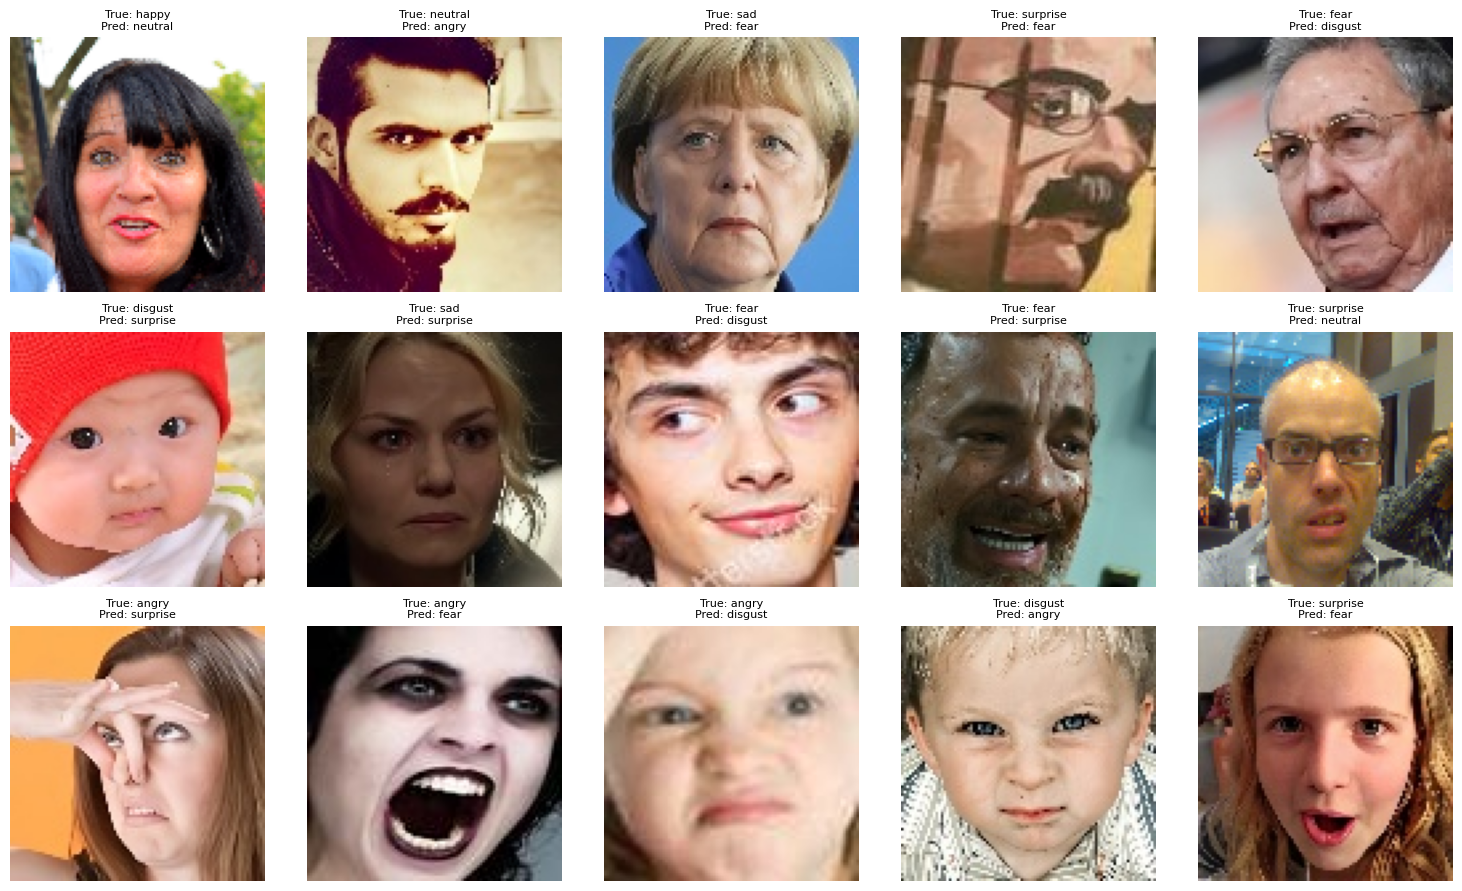

In [11]:
# Evaluate model on the whole dataset
predictions = classification_model.predict(images, batch_size=64)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = labels  # original labels loaded earlier

# Find indices where prediction is wrong
mistake_indices = np.where(predicted_labels != true_labels)[0]
print(f"Total mistakes: {len(mistake_indices)}")

# Get the filenames for the mistaken images from df
mistake_files = df.iloc[mistake_indices]["image"].tolist()
mistake_true = true_labels[mistake_indices]
mistake_pred = predicted_labels[mistake_indices]

# Show a grid of 15 mistaken images (if at least 15 exist)
n_display = min(15, len(mistake_indices))
sample_indices = np.random.choice(mistake_indices, n_display, replace=False)

expression_mapping = {
    "surprise": 0,
    "fear": 1,
    "disgust": 2,
    "happy": 3,
    "sad": 4,
    "angry": 5,
    "neutral": 6,
}
expression_mapping = {v: k for k, v in expression_mapping.items()}

fig, axes = plt.subplots(3, 5, figsize=(15, 9))
axes = axes.flatten()
for ax, idx in zip(axes, sample_indices):
    # Read image (using cv2) and convert from BGR to RGB for correct display.
    img = cv2.imread(df.iloc[idx]["image"])
    if img is None:
        # handle missing file gracefully
        ax.axis("off")
        continue
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    true_cls = true_labels[idx]
    pred_cls = predicted_labels[idx]
    ax.set_title(
        f"True: {expression_mapping[true_cls]}\nPred: {expression_mapping[pred_cls]}",
        fontsize=8,
    )
    ax.axis("off")

# Hide any extra subplots if less than 15 images are displayed
for ax in axes[n_display:]:
    ax.axis("off")
plt.tight_layout()
plt.show()


In [12]:
import numpy as np

# Select 60% of the mistake indices randomly
n_remove = int(0.6 * len(mistake_indices))
remove_idx = np.random.choice(mistake_indices, size=n_remove, replace=False)

df = df.drop(index=remove_idx)
print(f"Removed {n_remove} rows. New dataset shape: {df.shape}")

df.to_csv("merged_dataset.csv", index=False)

Removed 5233 rows. New dataset shape: (25119, 3)


Может это разметка датасета кривая? Может просто удалить из датасета все картинки, на которых он дает неправильный ответ ?? И эти полоски там тоже есть...